In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from os import path
import sys
sys.path.append(path.join(".."))

import saly
import saly.backend as S
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

EPOCHS = 6
SPECIES = 'Mouse'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
DATASET_HRVATIN_PATH = DATA_PATH + 'hrvatin_2018.h5ad' 
DATASET_CHEN_PATH = DATA_PATH + 'chen_2017.h5ad'
DATASET_BIG_PATH = DATA_PATH + '10x_mouse_1.3mln.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


In [2]:
hrvatin_data = saly.load_h5ad(DATASET_HRVATIN_PATH)
print("HRVATIN DATA\n", hrvatin_data.shape)

HRVATIN DATA
 (48266, 25186)


In [3]:
chen_data = saly.load_h5ad(DATASET_CHEN_PATH)
print("CHEN DATA\n", chen_data.shape)

CHEN DATA
 (14437, 23284)


In [4]:
big_data = saly.load_h5ad(DATASET_BIG_PATH)
print("BIG DATA\n", big_data.shape)

BIG DATA
 (1306127, 27932)


In [5]:
chen_data = saly.drop_rows(chen_data, ['tanycyte', 'unknown', 'ependymal cell', 'epithelial cell'])

Dropped 4750 cell(s). New shape: (9687, 23284)


In [6]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)
markers = saly.get_mutual_markers([hrvatin_data, chen_data, big_data], markers_db)
print('Mutual markers:', len(markers))

Mutual markers: 7382


In [7]:
marker_aliases = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes'}

saly.check_labels([hrvatin_data, chen_data], markers, marker_aliases)

In [8]:
hrvatin_data = saly.drop_unused_genes(hrvatin_data, markers)
chen_data = saly.drop_unused_genes(chen_data, markers)
big_data = saly.drop_unused_genes(big_data, markers)

saly.check_shape([hrvatin_data, chen_data, big_data])

Dropped 21107 gene(s). New shape: (48266, 4079)
Dropped 19205 gene(s). New shape: (9687, 4079)
Dropped 23853 gene(s). New shape: (1306127, 4079)


In [9]:
big_data = saly.mark_as_unlabelled(big_data.copy())

In [10]:
train_data, _, _ = saly.preprocess_data(big_data, splits=10,
                                       train=1, test=0, validation=0)

In [11]:
chen_data = S.normalize_data(chen_data.copy())
hrvatin_data = S.normalize_data(hrvatin_data.copy())

In [12]:
model, marker_model, encoder_model = saly.build_model(hrvatin_data, markers, supervised=False);

### Permute the genes

In [13]:
train_data = S.shuffle_data(train_data, axis=1)

In [15]:
idx = train_data.var_names
chen_data = chen_data[:, idx]
hrvatin_data = hrvatin_data[:, idx]

In [23]:
history = saly.train_model(model, train_data, markers, marker_aliases,
                           2, validation_data=chen_data, verbose=1)

Train on 1306127 samples, validate on 9687 samples
Epoch 1/2
1306127/1306127 [==============================] - 103s 79us/step - loss: 2073.9069 - cell_activations_loss: 0.0000e+00 - output_loss: 2.0739 - cell_activations_celltype_accuracy: 0.0372 - val_loss: 2928.6609 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 2.9287 - val_cell_activations_celltype_accuracy: 0.1082
Epoch 2/2
1306127/1306127 [==============================] - 101s 77us/step - loss: 2055.8911 - cell_activations_loss: 0.0000e+00 - output_loss: 2.0559 - cell_activations_celltype_accuracy: 0.0778 - val_loss: 2925.7985 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 2.9258 - val_cell_activations_celltype_accuracy: 0.0914


Correct predictions: 6623 out of 9687 (68.37%)
	Neuron: 42.07% (974/2315) | Markers: 197
	Oligodendrocyte: 77.15% (2732/3541) | Markers: 85
	OPC: 95.48% (1711/1792) | Markers: 28
	Astrocyte: 57.4% (659/1148) | Markers: 61
	Microglia: 70.99% (514/724) | Markers: 80
	Macrophage: 19.76% (33/167) | Markers: 130


KeyError: 'cell_activations_marker_prediction_metric'

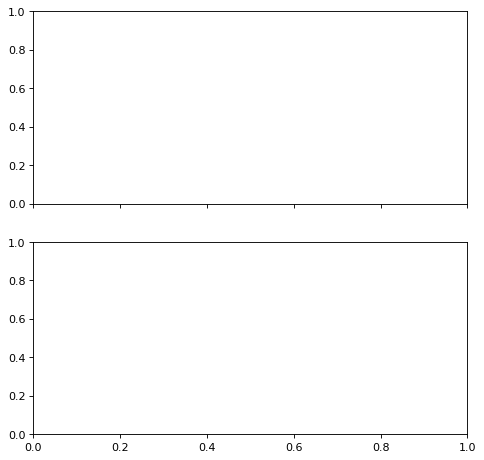

In [24]:
chen_baseline = saly.get_baseline(chen_data, markers)
validation_baseline = saly.get_results(chen_data.obs['labels'], chen_baseline.X.toarray(), markers, marker_aliases)

saly.plot_model_history(history, validation_baseline, supervised=False, labelled_training=False)

In [25]:
hrvatin_cell_activations = marker_model.predict(hrvatin_data.X)
saly.get_results(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases);

Correct predictions: 5622 out of 48266 (11.65%)
	Neuron: 30.93% (4708/15223) | Markers: 197
	Oligodendrocyte: 0.06% (5/8630) | Markers: 85
	Muscle cell: 0.0% (0/621) | Markers: 77
	Astrocyte: 0.34% (24/7039) | Markers: 61
	Endothelial cell: 25.62% (884/3450) | Markers: 178
	Macrophage: 0.19% (1/537) | Markers: 130
	Microglia: 0.0% (0/10158) | Markers: 80
	OPC: 0.0% (0/1826) | Markers: 28
	Pericyte: 0.0% (0/782) | Markers: 64


In [26]:
chen_cell_activations = marker_model.predict(chen_data.X)
saly.get_results(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases);

Correct predictions: 885 out of 9687 (9.14%)
	Neuron: 37.75% (874/2315) | Markers: 197
	Oligodendrocyte: 0.03% (1/3541) | Markers: 85
	OPC: 0.0% (0/1792) | Markers: 28
	Astrocyte: 0.87% (10/1148) | Markers: 61
	Microglia: 0.0% (0/724) | Markers: 80
	Macrophage: 0.0% (0/167) | Markers: 130


../saly/backend/analysis.py:104: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)
../saly/backend/analysis.py:105: RuntimeWarning: invalid value encountered in true_divide
  recall = tp / (tp + fn)
../saly/backend/analysis.py:106: RuntimeWarning: invalid value encountered in true_divide
  f1_score = 2 * (recall * precision) / (recall + precision)
/home/mlongar/miniconda/envs/MG/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


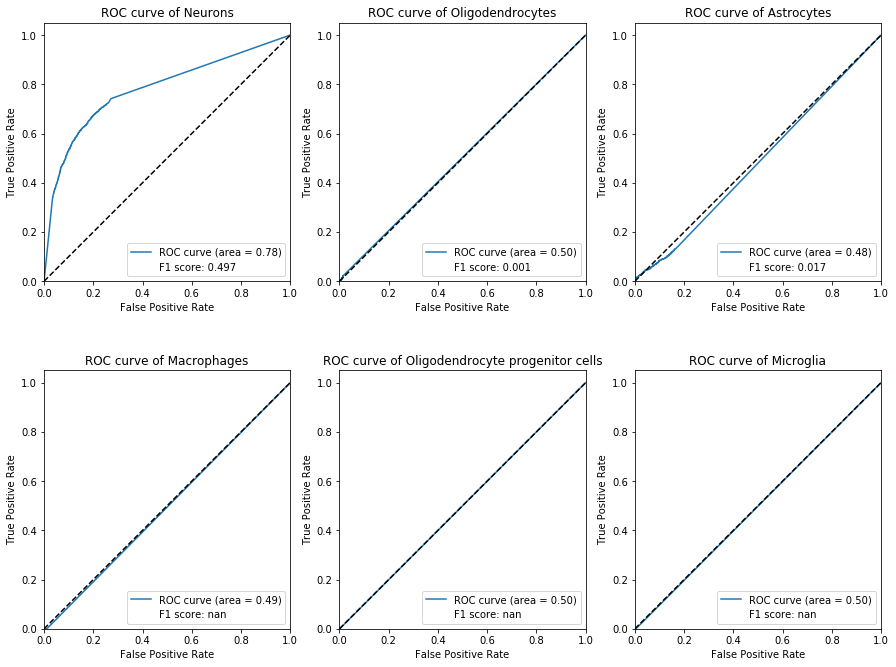

In [27]:
saly.draw_roc(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases)

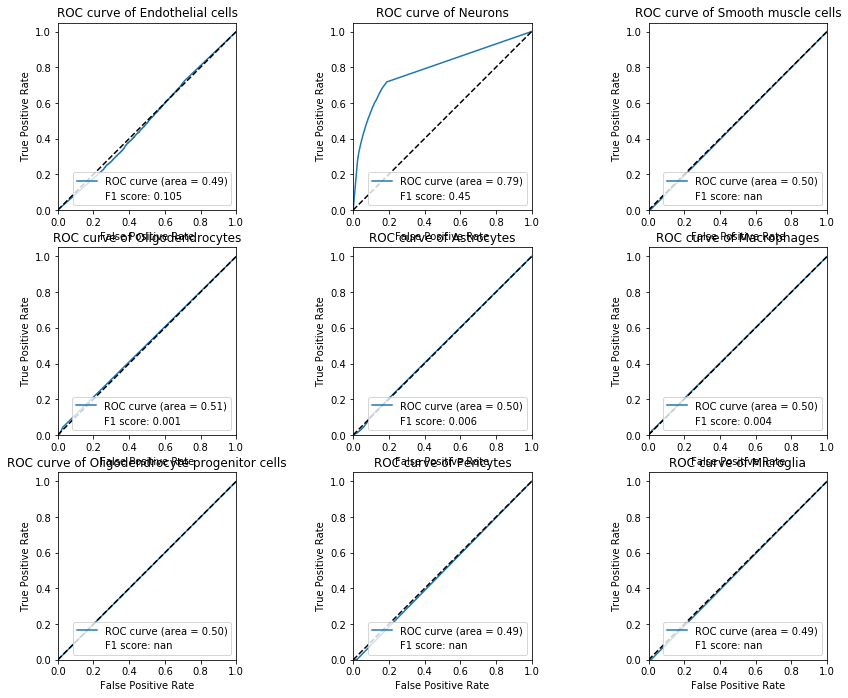

In [28]:
saly.draw_roc(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases)